# Understanding how the self-weighting LossVal loss functions affect the test performance of a model

This is the code for section 6.4, where we analyze if using a weighted loss during training affects the models performance afterward.

In [4]:
import numpy as np
import pandas as pd
import torch
import torcheval.metrics
from numpy import mean
from opendataval.dataloader import DataFetcher
from torch import nn
from tqdm.auto import tqdm

from src.baseline import MLP_hyperparameters as hyperparam
from src.baseline.run_baselines_classification import DATA_DIR
from src.baseline.utils import mixed_noise_function
from src.LossVal import loss_configurations
from src.LossVal.LossVal_MLP import LossVal_MLP
from src.LossVal.run_LossVal import REGRESSION_DATASETS, CLASSIFICATION_DATASETS

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NR_REPETITIONS = 15
NR_EPOCHS = 30

BATCH_SIZE_REGRESSION = hyperparam.REGRESSION_BATCH_SIZE
LEARNING_RATE_REGRESSION = hyperparam.REGRESSION_LEARNING_RATE
MLP_HYPERPARAM_REGRESSION = hyperparam.REGRESSION_MLP_HYPERPARAMETERS

BATCH_SIZE_CLASSIFICATION = hyperparam.CLASSIFIER_BATCH_SIZE
LEARNING_RATE_CLASSIFICATION = hyperparam.CLASSIFIER_LEARNING_RATE
MLP_HYPERPARAM_CLASSIFICATION = hyperparam.CLASSIFIER_MLP_HYPERPARAMETERS

In [6]:
def normal_mse(train_y_pred, train_y_true, *args, **kwargs):    # Just so that it works with our custom mlp
    # The target is a tensor with shape (batch_size, 1) where each element is the value of the target variable
    # The output is a tensor with shape (batch_size, 1) where each element is the predicted value of the target variable
    # The loss is the mean squared error between the output and the target
    return nn.functional.mse_loss(train_y_pred, train_y_true)

def normal_cross_entropy_loss(train_y_pred, train_y_true, *args, **kwargs):
    return nn.functional.cross_entropy(train_y_pred, train_y_true)

def r2_error(train_y_pred, train_y_true, *args, **kwargs):
    return torcheval.metrics.functional.r2_score(train_y_pred, train_y_true)

def accuracy(train_y_pred, train_y_true, *args, **kwargs):
    """ Simple accuracy implementation """
    return torch.mean((train_y_pred.argmax(dim=1) == train_y_true.argmax(dim=1)).float())

In [7]:
weighted_mse = loss_configurations.REGRESSION_LOSSES["Weighted MSE loss with squared Sinkhorn"]
weighted_cross_entropy = loss_configurations.CLASSIFICATION_LOSSES["Weighted CE loss with squared Sinkhorn"]

## Regression Dataset

In [8]:
results_list = []

tbar = tqdm(total=len(REGRESSION_DATASETS) * NR_REPETITIONS, desc="Evaluate regression datasets", unit="run")
for dataset in REGRESSION_DATASETS:
    fetcher = DataFetcher(dataset_name=dataset, cache_dir=DATA_DIR, force_download=False)
    
    for _ in range(NR_REPETITIONS):
        fetcher = fetcher.split_dataset_by_count(1000, 100, 3000)    # Use 1000 samples for training and 3000 for testing (identical to the other experiments)
        x_trn, y_trn, x_val, y_val, x_test, y_test = fetcher.datapoints
        x_trn, x_test, x_val, y_val, y_trn, y_test = x_trn.to(DEVICE), x_test.to(DEVICE), x_val.to(DEVICE), y_val.to(DEVICE), y_trn.to(DEVICE), y_test.to(DEVICE)
        
        # Create model (with the hyperparameters that are used in the main experiments):
        template_model = LossVal_MLP(
            input_dim=x_trn.shape[1],
            output_dim=1,
            hidden_dim=MLP_HYPERPARAM_REGRESSION["hidden_dim"],
            layers=MLP_HYPERPARAM_REGRESSION["layers"],
            training_set_size=x_trn.shape[0],
            is_classification=False,
            act_fn=MLP_HYPERPARAM_REGRESSION["act_fn"]
        ).to(DEVICE)
        
        # Evaluate normal MSE loss:
        model = template_model.clone()
        model.fit(x_train=x_trn, y_train=y_trn, loss_function=normal_mse, val_X=x_val, val_y=y_val, batch_size=BATCH_SIZE_REGRESSION, lr=LEARNING_RATE_REGRESSION, epochs=NR_EPOCHS)
        
        pred = model.predict(x_test)
        results_list.append((dataset, normal_mse(pred, y_test).item(), r2_error(pred, y_test).item(), "normal"))

        # Evaluate weighted loss:
        model = template_model.clone()
        model.fit(x_train=x_trn, y_train=y_trn, loss_function=weighted_mse, val_X=x_val, val_y=y_val, batch_size=BATCH_SIZE_REGRESSION, lr=LEARNING_RATE_REGRESSION, epochs=NR_EPOCHS)
        
        pred = model.predict(x_test)
        results_list.append((dataset, normal_mse(pred, y_test).item(), r2_error(pred, y_test).item(), "weighted"))
        
        tbar.update(1)

Evaluate regression datasets:   0%|          | 0/90 [00:00<?, ?run/s]

In [9]:
regr_results = pd.DataFrame(results_list, columns=["Dataset", "MSE", "R2", "mode"])
regr_results

,Dataset,MSE,R2,mode
0,kin8nm,0.186667,0.811905,normal
1,kin8nm,0.184090,0.814502,weighted
2,kin8nm,0.172655,0.825083,normal
3,kin8nm,0.181212,0.816414,weighted
4,kin8nm,0.165779,0.833049,normal
...,...,...,...,...
175,superconductivity,0.914565,0.059950,weighted
176,superconductivity,0.231156,0.774198,normal
177,superconductivity,0.561284,0.451718,weighted
178,superconductivity,0.209295,0.795302,normal


In [23]:
# t-test between normal and weighted loss:
from scipy.stats import ttest_rel, ttest_ind

normal_loss = regr_results[regr_results["mode"] == "normal"]["R2"].values
weighted_loss = regr_results[regr_results["mode"] == "weighted"]["R2"].values

tp = ttest_ind(normal_loss, weighted_loss)
print("Weighted loss is better" if mean(weighted_loss) < mean(normal_loss) else "Normal loss is better")
if tp.pvalue <= 0.1:
    print("The difference is significant!", tp)
else:
    print("p > 0.1  ->  the distributions are similar. p =", tp.pvalue)
    
print(tp)

Weighted loss is better
p > 0.1  ->  the distributions are similar. p = 0.17867486961870466
TtestResult(statistic=1.3501727153583427, pvalue=0.17867486961870466, df=178.0)


In [24]:
print("R2 mean difference:", mean(weighted_loss) - mean(normal_loss))

R2 mean difference: -0.06312553617689354


In [25]:
mean(weighted_loss), mean(normal_loss)

(0.6205433613724178, 0.6836688975493114)

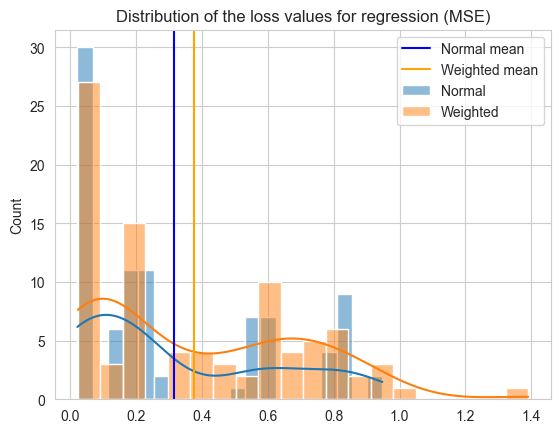

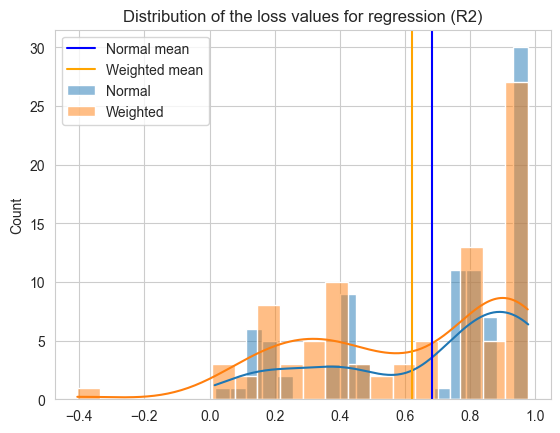

In [11]:
# Plot distributions:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(regr_results[regr_results["mode"] == "normal"]["MSE"].values, label="Normal", kde=True, bins=20)
sns.histplot(regr_results[regr_results["mode"] == "weighted"]["MSE"].values, label="Weighted", kde=True, bins=20)

# Add means:
plt.axvline(np.mean(regr_results[regr_results["mode"] == "normal"]["MSE"].values), color="blue", label="Normal mean")
plt.axvline(np.mean(regr_results[regr_results["mode"] == "weighted"]["MSE"].values), color="orange", label="Weighted mean")
plt.title("Distribution of the loss values for regression (MSE)")

plt.legend()
plt.show()

sns.histplot(regr_results[regr_results["mode"] == "normal"]["R2"].values, label="Normal", kde=True, bins=20)
sns.histplot(regr_results[regr_results["mode"] == "weighted"]["R2"].values, label="Weighted", kde=True, bins=20)

# Add means:
plt.axvline(np.mean(regr_results[regr_results["mode"] == "normal"]["R2"].values), color="blue", label="Normal mean")
plt.axvline(np.mean(regr_results[regr_results["mode"] == "weighted"]["R2"].values), color="orange", label="Weighted mean")
plt.title("Distribution of the loss values for regression (R2)")
# plt.xlim(0, 1)

plt.legend()
plt.show()

## Classification Dataset

In [12]:
results_list = []

tbar = tqdm(total=len(CLASSIFICATION_DATASETS) * NR_REPETITIONS, desc="Evaluate classification datasets", unit="run")
for dataset in CLASSIFICATION_DATASETS:
    fetcher = DataFetcher(dataset_name=dataset, cache_dir=DATA_DIR, force_download=False)
    
    for _ in range(NR_REPETITIONS):
        fetcher = fetcher.split_dataset_by_count(1000, 100, 3000)    # Use 1000 samples for training and 3000 for testing (identical to the other experiments)
        x_trn, y_trn, x_val, y_val, x_test, y_test = fetcher.datapoints
        x_trn, x_test, x_val, y_val, y_trn, y_test = x_trn.to(DEVICE), x_test.to(DEVICE), x_val.to(DEVICE), y_val.to(DEVICE), y_trn.to(DEVICE), y_test.to(DEVICE)

        # Create model (with the hyperparameters that are used in the main experiments):
        template_model = LossVal_MLP(
            input_dim=x_trn.shape[1],
            output_dim=y_trn.shape[1],
            hidden_dim=MLP_HYPERPARAM_CLASSIFICATION["hidden_dim"],
            layers=MLP_HYPERPARAM_CLASSIFICATION["layers"],
            training_set_size=x_trn.shape[0],
            is_classification=True,
            act_fn=MLP_HYPERPARAM_CLASSIFICATION["act_fn"]
        ).to(DEVICE)

        # Evaluate normal MSE loss:
        model = template_model.clone()
        model.fit(x_train=x_trn, y_train=y_trn, loss_function=normal_cross_entropy_loss, val_X=x_val, val_y=y_val, batch_size=BATCH_SIZE_CLASSIFICATION, lr=LEARNING_RATE_CLASSIFICATION, epochs=NR_EPOCHS)
        
        pred = model.predict(x_test)
        results_list.append((dataset, normal_cross_entropy_loss(pred, y_test).item(), accuracy(pred, y_test).item(), "normal"))

        # Evaluate weighted loss:
        model = template_model.clone()
        model.fit(x_train=x_trn, y_train=y_trn, loss_function=weighted_cross_entropy, val_X=x_val, val_y=y_val, batch_size=BATCH_SIZE_CLASSIFICATION, lr=LEARNING_RATE_CLASSIFICATION, epochs=NR_EPOCHS)
        
        pred = model.predict(x_test)
        results_list.append((dataset, normal_cross_entropy_loss(pred, y_test).item(), accuracy(pred, y_test).item(), "weighted"))
        
        tbar.update(1)

Evaluate classification datasets:   0%|          | 0/90 [00:00<?, ?run/s]

In [13]:
classification_results = pd.DataFrame(results_list, columns=["Dataset", "Cross-Entropy", "Accuracy", "mode"])
classification_results

,Dataset,Cross-Entropy,Accuracy,mode
0,2dplanes,0.825262,0.488000,normal
1,2dplanes,0.801262,0.512000,weighted
2,2dplanes,0.811928,0.501333,normal
3,2dplanes,0.811928,0.501333,weighted
4,2dplanes,0.815928,0.497333,normal
...,...,...,...,...
175,nomao,0.603595,0.709667,weighted
176,nomao,0.601595,0.711667,normal
177,nomao,0.601595,0.711667,weighted
178,nomao,0.605595,0.707667,normal


In [22]:
# t-test between normal and weighted loss:
from scipy.stats import ttest_rel, ttest_ind   
normal_loss = classification_results[classification_results["mode"] == "normal"]["Accuracy"].values
weighted_loss = classification_results[classification_results["mode"] == "weighted"]["Accuracy"].values

tp = ttest_ind(normal_loss, weighted_loss)
if tp.pvalue <= 0.1:
    print("The difference is significant!", tp)
else:
    print("p > 0.1  ->  the distributions are similar. p =", tp.pvalue)
    
print(tp)

p > 0.1  ->  the distributions are similar. p = 0.9956277865871117
TtestResult(statistic=-0.005487486231096232, pvalue=0.9956277865871117, df=178.0)


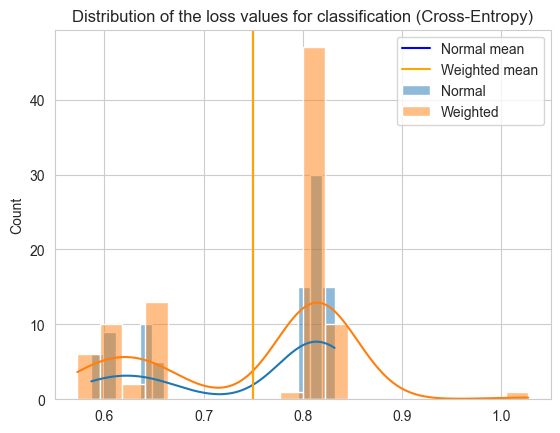

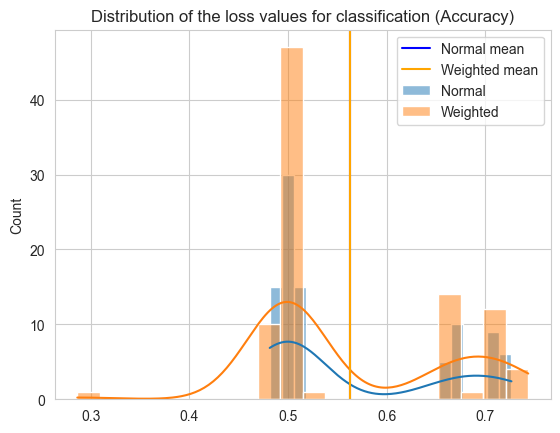

In [15]:
# Plot distributions:
sns.histplot(classification_results[classification_results["mode"] == "normal"]["Cross-Entropy"].values, label="Normal", kde=True, bins=20)
sns.histplot(classification_results[classification_results["mode"] == "weighted"]["Cross-Entropy"].values, label="Weighted", kde=True, bins=20)

# Add means:
plt.axvline(np.mean(classification_results[classification_results["mode"] == "normal"]["Cross-Entropy"].values), color="blue", label="Normal mean")
plt.axvline(np.mean(classification_results[classification_results["mode"] == "weighted"]["Cross-Entropy"].values), color="orange", label="Weighted mean")

plt.title("Distribution of the loss values for classification (Cross-Entropy)")
plt.legend()
plt.show()

sns.histplot(classification_results[classification_results["mode"] == "normal"]["Accuracy"].values, label="Normal", kde=True, bins=20)
sns.histplot(classification_results[classification_results["mode"] == "weighted"]["Accuracy"].values, label="Weighted", kde=True, bins=20)

# Add means:
plt.axvline(np.mean(classification_results[classification_results["mode"] == "normal"]["Accuracy"].values), color="blue", label="Normal mean")
plt.axvline(np.mean(classification_results[classification_results["mode"] == "weighted"]["Accuracy"].values), color="orange", label="Weighted mean")

# plt.xlim(0, 1)
plt.title("Distribution of the loss values for classification (Accuracy)")
plt.legend()
plt.show()

In [16]:
# Save results:
import os

regr_results.to_csv(os.path.abspath("./../../results/effect_of_weighting/regression.csv"), index=False)
classification_results.to_csv(os.path.abspath("./../../results/effect_of_weighting/classification.csv"), index=False)

## Repeat with 20% mixed noise

### Regression Dataset

In [16]:
results_list = []

tbar = tqdm(total=len(REGRESSION_DATASETS) * NR_REPETITIONS, desc="Evaluate regression datasets", unit="run")
for dataset in REGRESSION_DATASETS:
    for _ in range(NR_REPETITIONS):
        fetcher = DataFetcher(dataset_name=dataset, cache_dir=DATA_DIR, force_download=False)
        fetcher = fetcher.split_dataset_by_count(1000, 100, 3000)    # Use 1000 samples for training and 3000 for testing (identical to the other experiments)
        fetcher = fetcher.noisify(mixed_noise_function, noise_rate=0.2)
        
        x_trn, y_trn, x_val, y_val, x_test, y_test = fetcher.datapoints
        x_trn, x_test, x_val, y_val, y_trn, y_test = x_trn.to(DEVICE), x_test.to(DEVICE), x_val.to(DEVICE), y_val.to(DEVICE), y_trn.to(DEVICE), y_test.to(DEVICE)
        
        # Create model (with the hyperparameters that are used in the main experiments):
        template_model = LossVal_MLP(
            input_dim=x_trn.shape[1],
            output_dim=1,
            hidden_dim=MLP_HYPERPARAM_REGRESSION["hidden_dim"],
            layers=MLP_HYPERPARAM_REGRESSION["layers"],
            training_set_size=x_trn.shape[0],
            is_classification=False,
            act_fn=MLP_HYPERPARAM_REGRESSION["act_fn"]
        ).to(DEVICE)
        
        # Evaluate normal MSE loss:
        model = template_model.clone()
        model.fit(x_train=x_trn, y_train=y_trn, loss_function=normal_mse, val_X=x_val, val_y=y_val, batch_size=BATCH_SIZE_REGRESSION, lr=LEARNING_RATE_REGRESSION, epochs=NR_EPOCHS)
        
        pred = model.predict(x_test)
        results_list.append((dataset, normal_mse(pred, y_test).item(), r2_error(pred, y_test).item(), "normal"))

        # Evaluate weighted loss:
        model = template_model.clone()
        model.fit(x_train=x_trn, y_train=y_trn, loss_function=weighted_mse, val_X=x_val, val_y=y_val, batch_size=BATCH_SIZE_REGRESSION, lr=LEARNING_RATE_REGRESSION, epochs=NR_EPOCHS)
        
        pred = model.predict(x_test)
        results_list.append((dataset, normal_mse(pred, y_test).item(), r2_error(pred, y_test).item(), "weighted"))
        
        tbar.update(1)

Evaluate regression datasets:   0%|          | 0/30 [00:00<?, ?run/s]

In [17]:
regr_results = pd.DataFrame(results_list, columns=["Dataset", "MSE", "R2", "mode"])
regr_results

,Dataset,MSE,R2,mode
0,kin8nm,0.378107,0.621849,normal
1,kin8nm,0.271660,0.728309,weighted
2,kin8nm,0.348224,0.641034,normal
3,kin8nm,0.273068,0.718508,weighted
4,kin8nm,0.335608,0.683490,normal
5,kin8nm,0.258403,0.756302,weighted
6,kin8nm,0.335806,0.667528,normal
7,kin8nm,0.358947,0.644617,weighted
8,kin8nm,0.364238,0.628984,normal
9,kin8nm,0.438533,0.553307,weighted


In [19]:
# t-test between normal and weighted loss:
from scipy.stats import ttest_rel   
normal_loss = regr_results[regr_results["mode"] == "normal"]["MSE"].values
weighted_loss = regr_results[regr_results["mode"] == "weighted"]["MSE"].values

tp = ttest_rel(normal_loss, weighted_loss)
if tp.pvalue <= 0.1:
    print("The difference is significant!", tp)
else:
    print("p > 0.1  ->  the distributions are similar. p =", tp.pvalue)
    
print(tp)

p > 0.1  ->  the distributions are similar. p = 0.94882941126211


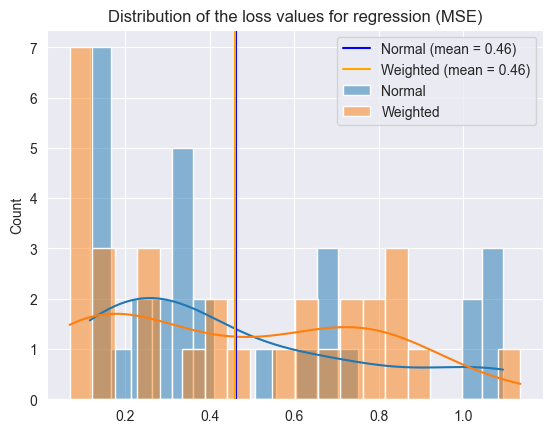

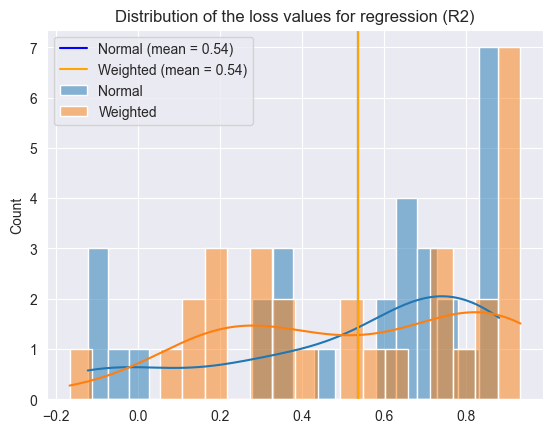

In [31]:
# Plot distributions:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(regr_results[regr_results["mode"] == "normal"]["MSE"].values, label="Normal", kde=True, bins=20)
sns.histplot(regr_results[regr_results["mode"] == "weighted"]["MSE"].values, label="Weighted", kde=True, bins=20)

# Add means:
mean_normal = np.mean(regr_results[regr_results["mode"] == "normal"]["MSE"].values)
mean_weighted = np.mean(regr_results[regr_results["mode"] == "weighted"]["MSE"].values)
plt.axvline(mean_normal, color="blue", label=f"Normal (mean = {mean_normal:.2f})")
plt.axvline(mean_weighted, color="orange", label=f"Weighted (mean = {mean_weighted:.2f})")
plt.title("Distribution of the loss values for regression (MSE)")

plt.legend()
plt.show()

sns.histplot(regr_results[regr_results["mode"] == "normal"]["R2"].values, label="Normal", kde=True, bins=20)
sns.histplot(regr_results[regr_results["mode"] == "weighted"]["R2"].values, label="Weighted", kde=True, bins=20)

# Add means:
mean_normal = np.mean(regr_results[regr_results["mode"] == "normal"]["R2"].values)
mean_weighted = np.mean(regr_results[regr_results["mode"] == "weighted"]["R2"].values)
plt.axvline(mean_normal, color="blue", label=f"Normal (mean = {mean_normal:.2f})")
plt.axvline(mean_weighted, color="orange", label=f"Weighted (mean = {mean_weighted:.2f})")
plt.title("Distribution of the loss values for regression (R2)")
# plt.xlim(0, 1)

plt.legend()
plt.show()

### Classification Dataset

In [21]:
results_list = []

tbar = tqdm(total=len(REGRESSION_DATASETS) * NR_REPETITIONS, desc="Evaluate classification datasets", unit="run")
for dataset in REGRESSION_DATASETS:
    for _ in range(NR_REPETITIONS):
        fetcher = DataFetcher(dataset_name=dataset, cache_dir=DATA_DIR, force_download=False)
        fetcher = fetcher.split_dataset_by_count(1000, 100, 3000)    # Use 1000 samples for training and 3000 for testing (identical to the other experiments)
        fetcher = fetcher.noisify(mixed_noise_function, noise_rate=0.2)

        x_trn, y_trn, x_val, y_val, x_test, y_test = fetcher.datapoints
        x_trn, x_test, x_val, y_val, y_trn, y_test = x_trn.to(DEVICE), x_test.to(DEVICE), x_val.to(DEVICE), y_val.to(DEVICE), y_trn.to(DEVICE), y_test.to(DEVICE)

        # Create model (with the hyperparameters that are used in the main experiments):
        template_model = LossVal_MLP(
            input_dim=x_trn.shape[1],
            output_dim=y_trn.shape[1],
            hidden_dim=MLP_HYPERPARAM_CLASSIFICATION["hidden_dim"],
            layers=MLP_HYPERPARAM_CLASSIFICATION["layers"],
            training_set_size=x_trn.shape[0],
            is_classification=True,
            act_fn=MLP_HYPERPARAM_CLASSIFICATION["act_fn"]
        ).to(DEVICE)

        # Evaluate normal MSE loss:
        model = template_model.clone()
        model.fit(x_train=x_trn, y_train=y_trn, loss_function=normal_cross_entropy_loss, val_X=x_val, val_y=y_val, batch_size=BATCH_SIZE_CLASSIFICATION, lr=LEARNING_RATE_CLASSIFICATION, epochs=NR_EPOCHS)
        
        pred = model.predict(x_test)
        results_list.append((dataset, normal_cross_entropy_loss(pred, y_test).item(), accuracy(pred, y_test).item(), "normal"))

        # Evaluate weighted loss:
        model = template_model.clone()
        model.fit(x_train=x_trn, y_train=y_trn, loss_function=weighted_cross_entropy, val_X=x_val, val_y=y_val, batch_size=BATCH_SIZE_CLASSIFICATION, lr=LEARNING_RATE_CLASSIFICATION, epochs=NR_EPOCHS)
        
        pred = model.predict(x_test)
        results_list.append((dataset, normal_cross_entropy_loss(pred, y_test).item(), accuracy(pred, y_test).item(), "weighted"))
        
        tbar.update(1)

Evaluate classification datasets:   0%|          | 0/30 [00:00<?, ?run/s]

In [22]:
classification_results = pd.DataFrame(results_list, columns=["Dataset", "Cross-Entropy", "Accuracy", "mode"])
classification_results

,Dataset,Cross-Entropy,Accuracy,mode
0,kin8nm,-0.0,1.0,normal
1,kin8nm,-0.0,1.0,weighted
2,kin8nm,-0.0,1.0,normal
3,kin8nm,-0.0,1.0,weighted
4,kin8nm,-0.0,1.0,normal
5,kin8nm,-0.0,1.0,weighted
6,kin8nm,-0.0,1.0,normal
7,kin8nm,-0.0,1.0,weighted
8,kin8nm,-0.0,1.0,normal
9,kin8nm,-0.0,1.0,weighted


In [23]:
# t-test between normal and weighted loss:
from scipy.stats import ttest_rel   
normal_loss = classification_results[classification_results["mode"] == "normal"]["Cross-Entropy"].values
weighted_loss = classification_results[classification_results["mode"] == "weighted"]["Cross-Entropy"].values

tp = ttest_rel(normal_loss, weighted_loss)
print("Weighted loss is better" if mean(weighted_loss) < mean(normal_loss) else "Normal loss is better")
if tp.pvalue <= 0.1:
    print("The difference is significant!", tp)
else:
    print("p > 0.1  ->  the distributions are similar. p =", tp.pvalue)
    
print(tp)

p > 0.1  ->  the distributions are similar. p = nan


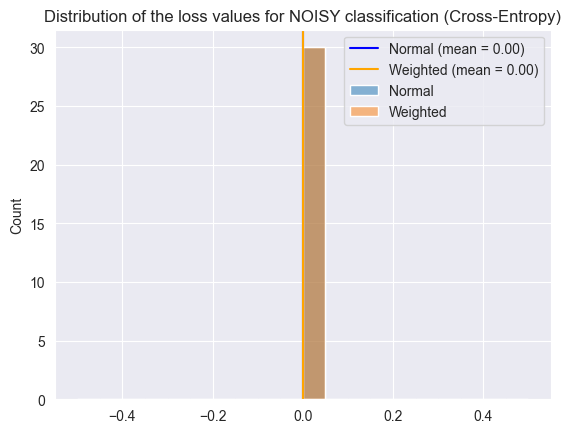

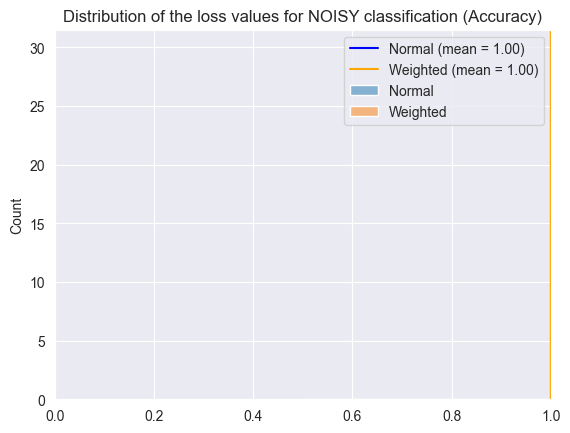

In [32]:
# Plot distributions:
sns.histplot(classification_results[classification_results["mode"] == "normal"]["Cross-Entropy"].values, label="Normal", kde=True, bins=20)
sns.histplot(classification_results[classification_results["mode"] == "weighted"]["Cross-Entropy"].values, label="Weighted", kde=True, bins=20)

# Add means:
mean_normal = np.mean(classification_results[classification_results["mode"] == "normal"]["Cross-Entropy"].values)
mean_weighted = np.mean(classification_results[classification_results["mode"] == "weighted"]["Cross-Entropy"].values)
plt.axvline(mean_normal, color="blue", label=f"Normal (mean = {mean_normal:.2f})")
plt.axvline(mean_weighted, color="orange", label=f"Weighted (mean = {mean_weighted:.2f})")

plt.title("Distribution of the loss values for NOISY classification (Cross-Entropy)")
plt.legend()
plt.show()

sns.histplot(classification_results[classification_results["mode"] == "normal"]["Accuracy"].values, label="Normal", kde=True, bins=20)
sns.histplot(classification_results[classification_results["mode"] == "weighted"]["Accuracy"].values, label="Weighted", kde=True, bins=20)

# Add means:
mean_normal = np.mean(classification_results[classification_results["mode"] == "normal"]["Accuracy"].values)
mean_weighted = np.mean(classification_results[classification_results["mode"] == "weighted"]["Accuracy"].values)
plt.axvline(mean_normal, color="blue", label=f"Normal (mean = {mean_normal:.2f})")
plt.axvline(mean_weighted, color="orange", label=f"Weighted (mean = {mean_weighted:.2f})")

plt.xlim(0, 1)
plt.title("Distribution of the loss values for NOISY classification (Accuracy)")
plt.legend()
plt.show()

In [25]:
# Save results:
import os

regr_results.to_csv(os.path.abspath("./../../results/effect_of_weighting/noisy_regression.csv"), index=False)
classification_results.to_csv(os.path.abspath("./../../results/effect_of_weighting/noisy_classification.csv"), index=False)